<h1 align="center">Text-To-Speech Transformer</h1>

In [1]:
pip install -U encodec  # stable release

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.7/3.7 MB 34.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - \ done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 4.1 MB/s eta 0:00:00
  Created wheel for encodec: filename=encodec-0.1.1-py3-none-any.whl size=45779 sha256=5a3c5e240e212453dfb7b984f3d7d1b5dac0d42922730c3a1321a49c1700914d
  Stored in directory: /root/.cache/pip/wheels/fc/36/cb/81af8b985a5f5e0815312d5e52b41263237af07b977e6bcbf3
Successfully built encodec
Note: you may need to restart the kernel to use updated packages.


## Understanding and Encoding the data

In [2]:
from encodec import EncodecModel
from encodec.utils import convert_audio

import torchaudio
import torch

# Instantiate a pretrained EnCodec model
model = EncodecModel.encodec_model_24khz()
# The number of codebooks used will be determined bythe bandwidth selected.
# E.g. for a bandwidth of 6kbps, `n_q = 8` codebooks are used.
# Supported bandwidths are 1.5kbps (n_q = 2), 3 kbps (n_q = 4), 6 kbps (n_q = 8) and 12 kbps (n_q =16) and 24kbps (n_q=32).
# For the 48 kHz model, only 3, 6, 12, and 24 kbps are supported. The number
# of codebooks for each is half that of the 24 kHz model as the frame rate is twice as much.
model.set_target_bandwidth(6.0)

# Load and pre-process the audio waveform
wav, sr = torchaudio.load("/kaggle/input/the-lj-speech-dataset/LJSpeech-1.1/wavs/LJ001-0001.wav")
wav = convert_audio(wav, sr, model.sample_rate, model.channels)
wav = wav.unsqueeze(0)

# Extract discrete codes from EnCodec
with torch.no_grad():
    encoded_frames = model.encode(wav)
codes = encoded_frames[0][0]

# to decode
back = [{codes,None}]

from encodec.utils import save_audio

save_audio(model.decode(back).reshape(1,-1), './test2.wav',  model.sample_rate)

Downloading: "https://dl.fbaipublicfiles.com/encodec/v0/encodec_24khz-d7cc33bc.th" to /root/.cache/torch/hub/checkpoints/encodec_24khz-d7cc33bc.th
100%|██████████| 88.9M/88.9M [00:00<00:00, 153MB/s]


In [3]:
import pandas as pd

df = pd.read_csv('/kaggle/input/the-lj-speech-dataset/LJSpeech-1.1/metadata.csv', sep='|', names=["File", "Transcription", "Transcription2"])
df.head()

,File,Transcription,Transcription2
0,LJ001-0001,"Printing, in the only sense with which we are ...","Printing, in the only sense with which we are ..."
1,LJ001-0002,in being comparatively modern.,in being comparatively modern.
2,LJ001-0003,For although the Chinese took impressions from...,For although the Chinese took impressions from...
3,LJ001-0004,"produced the block books, which were the immed...","produced the block books, which were the immed..."
4,LJ001-0005,the invention of movable metal letters in the ...,the invention of movable metal letters in the ...


There seems to be 2 columns for the audio transcription which is not what I expected

In [4]:
sum(df.Transcription == df.Transcription2), len(df.Transcription)

(11579, 13100)

They are almost similar except for about 1500 rows.

In [5]:
for i in range(5):
    print('-----------------------------------------')
    row = df[df.Transcription != df.Transcription2].iloc[i]
    print(row.Transcription)
    print("")
    print(row.Transcription2)

-----------------------------------------
the earliest book printed with movable types, the Gutenberg, or "forty-two line Bible" of about 1455,

the earliest book printed with movable types, the Gutenberg, or "forty-two line Bible" of about fourteen fifty-five,
-----------------------------------------
But the first Bible actually dated (which also was printed at Maintz by Peter Schoeffer in the year 1462)

But the first Bible actually dated (which also was printed at Maintz by Peter Schoeffer in the year fourteen sixty-two)
-----------------------------------------
In 1465 Sweynheim and Pannartz began printing in the monastery of Subiaco near Rome,

In fourteen sixty-five Sweynheim and Pannartz began printing in the monastery of Subiaco near Rome,
-----------------------------------------
They printed very few books in this type, three only; but in their very first books in Rome, beginning with the year 1468,

They printed very few books in this type, three only; but in their very fir

The difference between the rows seems to be that the first row always shows years as numbers while the second shows years as text. Based on this, I think I will stick to the second all-text row.

In [6]:
import wave
import contextlib
import os
import numpy as np
from tqdm import tqdm

direc = '/kaggle/input/the-lj-speech-dataset/LJSpeech-1.1/wavs'

model = EncodecModel.encodec_model_24khz()
model.set_target_bandwidth(6.0)


durations = []
encodes = []
channels = []

filelist = os.listdir(direc)

# for fname in tqdm(filelist):
#     with contextlib.closing(wave.open(direc+'/'+fname,'r')) as f:
#         frames = f.getnframes()
#         rate = f.getframerate()
#         duration = frames / float(rate)
#         durations.append(duration)

            
# durations = np.array(durations)
# print(len(durations), durations.mean(), durations.max(), durations.min())

Unequal audio durations which will lead to unequal audio representations, at least in length. This will have to be dealt with. Probably by finding the longest audio and its correspondent audio representation and finding its length. After that, I will fix the sequence length to that length and any audios that are shorter will have their remaining audio representation filled with zeroes.

In [7]:
from torch.nn.functional import pad
import torch


test_tensor = torch.tensor([0,1,2,3, 4,5,6,7])
if len(test_tensor) < 10:
    test_tensor = torch.cat([test_tensor, torch.zeros(10-len(test_tensor))])
test_tensor

tensor([0., 1., 2., 3., 4., 5., 6., 7., 0., 0.])

I want to create a basic transformer that takes as block_size the length of the longest transcription so that I can also force all my text inputs to be of fixed length. Transcriptions that are shorter than the longest text length will be extended with a specific token (probably zero). That way I have a very basic pipeline of having fixed length inputs and fixed length outputs and then I can just attempt to reconstruct audio from the outputs. I do not know if this will work, especially the reconstruction part, but I do not want to make anything advanced yet.

In [8]:
df = pd.read_csv('/kaggle/input/the-lj-speech-dataset/LJSpeech-1.1/metadata.csv', sep='|', names=["File", "Transcription2", "Transcription"]).drop(columns=['Transcription2']).dropna()


all_text = ''
longest_txt = 0


for txt in df.iterrows():
    try:
        all_text += txt[1].Transcription
    except:
        print(txt[1].Transcription)
    
    if len(txt[1].Transcription) > longest_txt:
        longest_txt = len(txt[1].Transcription)
    
chars = sorted(list(set(all_text)))
vocab_size = len(chars)
print(''.join(chars))
print(vocab_size)

 !"'(),-.:;?ABCDEFGHIJKLMNOPQRSTUVWXYZ[]abcdefghijklmnopqrstuvwxyzàâèéêü’“”
75


In [9]:
# create a mapping from characters to integers
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
stoi

# My Null character will be underscore
stoi['_'] = 75
itos[75] = '_'

stoi, itos

({' ': 0,
  '!': 1,
  '"': 2,
  "'": 3,
  '(': 4,
  ')': 5,
  ',': 6,
  '-': 7,
  '.': 8,
  ':': 9,
  ';': 10,
  '?': 11,
  'A': 12,
  'B': 13,
  'C': 14,
  'D': 15,
  'E': 16,
  'F': 17,
  'G': 18,
  'H': 19,
  'I': 20,
  'J': 21,
  'K': 22,
  'L': 23,
  'M': 24,
  'N': 25,
  'O': 26,
  'P': 27,
  'Q': 28,
  'R': 29,
  'S': 30,
  'T': 31,
  'U': 32,
  'V': 33,
  'W': 34,
  'X': 35,
  'Y': 36,
  'Z': 37,
  '[': 38,
  ']': 39,
  'a': 40,
  'b': 41,
  'c': 42,
  'd': 43,
  'e': 44,
  'f': 45,
  'g': 46,
  'h': 47,
  'i': 48,
  'j': 49,
  'k': 50,
  'l': 51,
  'm': 52,
  'n': 53,
  'o': 54,
  'p': 55,
  'q': 56,
  'r': 57,
  's': 58,
  't': 59,
  'u': 60,
  'v': 61,
  'w': 62,
  'x': 63,
  'y': 64,
  'z': 65,
  'à': 66,
  'â': 67,
  'è': 68,
  'é': 69,
  'ê': 70,
  'ü': 71,
  '’': 72,
  '“': 73,
  '”': 74,
  '_': 75},
 {0: ' ',
  1: '!',
  2: '"',
  3: "'",
  4: '(',
  5: ')',
  6: ',',
  7: '-',
  8: '.',
  9: ':',
  10: ';',
  11: '?',
  12: 'A',
  13: 'B',
  14: 'C',
  15: 'D',
  16: '

In [10]:
encode = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
decode = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string

print(encode("hii there"))
print(decode(encode("hii there")))

[47, 48, 48, 0, 59, 47, 44, 57, 44]
hii there


In [11]:
longest_txt

187

In [12]:
import os
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

class AudioDataset(Dataset):
    def __init__(self,train):
        self.data = pd.read_csv('/kaggle/input/the-lj-speech-dataset/LJSpeech-1.1/metadata.csv', sep='|', names=["File", "Transcription2", "Transcription"]).drop(columns=['Transcription2']).dropna().iloc[:20]
        
        if train:
            self.data = self.data.iloc[:len(self.data)*8//10]
        else:
            self.data = self.data.iloc[len(self.data)*8//10:]
        
        self.model = EncodecModel.encodec_model_24khz()
        
        self.model.set_target_bandwidth(6.0)
        

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        text = torch.tensor(encode(row.Transcription), dtype=torch.long)
        if len(text) < 200:
            text = torch.cat([text, torch.ones(200-len(text))*75])
        
        wav, sr = torchaudio.load("/kaggle/input/the-lj-speech-dataset/LJSpeech-1.1/wavs/"+row.File+".wav")
        wav = convert_audio(wav, sr, self.model.sample_rate, self.model.channels)
        wav = wav.unsqueeze(0)

        # Extract discrete codes from EnCodec
        with torch.no_grad():
            encoded_frames = self.model.encode(wav)
        audio = encoded_frames[0][0]
        audio = audio.reshape(-1)
        if len(audio) < 32000:
            audio = torch.cat([audio, torch.zeros(32000-len(audio))])
        elif len(audio) > 32000:
            raise Exception('Longer audio representation than fixed length')
        
        return text.to(torch.long), audio

In [13]:
train_data = AudioDataset(train=True)
val_data = AudioDataset(train=False)

In [14]:
len(train_data), len(val_data)

(16, 4)

In [15]:
train_data[0][1], train_data[0][1].shape

(tensor([780., 194., 887.,  ...,   0.,   0.,   0.]), torch.Size([32000]))

In [16]:
train_data[0][0], train_data[0][0].shape

(tensor([27, 57, 48, 53, 59, 48, 53, 46,  6,  0, 48, 53,  0, 59, 47, 44,  0, 54,
         53, 51, 64,  0, 58, 44, 53, 58, 44,  0, 62, 48, 59, 47,  0, 62, 47, 48,
         42, 47,  0, 62, 44,  0, 40, 57, 44,  0, 40, 59,  0, 55, 57, 44, 58, 44,
         53, 59,  0, 42, 54, 53, 42, 44, 57, 53, 44, 43,  6,  0, 43, 48, 45, 45,
         44, 57, 58,  0, 45, 57, 54, 52,  0, 52, 54, 58, 59,  0, 48, 45,  0, 53,
         54, 59,  0, 45, 57, 54, 52,  0, 40, 51, 51,  0, 59, 47, 44,  0, 40, 57,
         59, 58,  0, 40, 53, 43,  0, 42, 57, 40, 45, 59, 58,  0, 57, 44, 55, 57,
         44, 58, 44, 53, 59, 44, 43,  0, 48, 53,  0, 59, 47, 44,  0, 16, 63, 47,
         48, 41, 48, 59, 48, 54, 53, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75,
         75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75,
         75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75,
         75, 75]),
 torch.Size([200]))

In [17]:
from torch.utils.data import DataLoader

batch_size = 100

trainloader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=0)
valloader = DataLoader(val_data, batch_size=batch_size, shuffle=False, num_workers=0)

dataloaders = {'train':trainloader, 'val':valloader}
dataset_sizes = {'train':len(train_data), 'val':len(val_data)}

In [18]:
import torch
import torch.nn as nn
from torch.nn import functional as F

In [19]:
# hyperparameters
device = 'cuda' if torch.cuda.is_available() else 'cpu'
n_embd = 64
n_head = 4
n_layer = 4
dropout = 0.0
block_size = 200
# ------------

In [20]:
device

'cuda'

In [21]:
torch.manual_seed(1337)

In [22]:
class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size):
        super().__init__()
        # Linear Layers to generate key,query and value matrices from the input x
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        
        # The tril that is used for the matrix aggregation trick is registered as a buffer
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))
        
        # Used dropout to prevent overfitting
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B,T,C = x.shape
        k = self.key(x)   # (B,T,C)
        q = self.query(x) # (B,T,C)
        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2,-1) * C**-0.5 # (B, T, C) @ (B, C, T) -> (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        wei = self.dropout(wei)
        # perform the weighted aggregation of the values
        v = self.value(x) # (B,T,C)
        out = wei @ v # (B, T, T) @ (B, T, C) -> (B, T, C)
        return out

class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        # This extra linear layer allows the heads to "think" about their assigned attention values
        self.proj = nn.Linear(n_embd, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

class FeedFoward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)

class Block(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, n_embd, n_head):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedFoward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x

# super simple bigram model
class BigramLanguageModel(nn.Module):

    def __init__(self, vocab_size=65):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        # We now encode position and add it to our encoding
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        
        self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd) # final layer norm
        self.lm_head = nn.Linear(n_embd, vocab_size)

    def forward(self, idx, targets=None):
        B, T = idx.shape

        # idx and targets are both (B,T) tensor of integers
        tok_emb = self.token_embedding_table(idx) # (B,T,C)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,C)
        x = tok_emb + pos_emb # (B,T,C)
        x = x.double()
        x = self.blocks(x) # (B,T,C)
        x = self.ln_f(x) # (B,T,C)
        logits = self.lm_head(x) # (B,T,vocab_size)

        return logits

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            idx_cond = idx[:, -block_size:]
            # get the predictions
            logits, loss = self(idx_cond)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx

In [23]:
from torch.nn import DataParallel

model = BigramLanguageModel(vocab_size = 76)

model.lm_head = torch.nn.Linear(in_features=64, out_features=160, bias=True)

# Check if multiple GPUs available
if torch.cuda.device_count() > 1:
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    # dim = 0 [30, xxx] -> [10, ...], [10, ...], [10, ...] on 3 GPUs
    model = DataParallel(model)

model = model.to(device)

Let's use 2 GPUs!


In [24]:
model

DataParallel(
  (module): BigramLanguageModel(
    (token_embedding_table): Embedding(76, 64)
    (position_embedding_table): Embedding(200, 64)
    (blocks): Sequential(
      (0): Block(
        (sa): MultiHeadAttention(
          (heads): ModuleList(
            (0-3): 4 x Head(
              (key): Linear(in_features=64, out_features=16, bias=False)
              (query): Linear(in_features=64, out_features=16, bias=False)
              (value): Linear(in_features=64, out_features=16, bias=False)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (proj): Linear(in_features=64, out_features=64, bias=True)
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (ffwd): FeedFoward(
          (net): Sequential(
            (0): Linear(in_features=64, out_features=256, bias=True)
            (1): ReLU()
            (2): Linear(in_features=256, out_features=64, bias=True)
            (3): Dropout(p=0.0, inplace=False)
          )
     

In [25]:
!mkdir models

In [26]:
# for inputs, labels in dataloaders['train']:
#     print(inputs,inputs.shape, inputs.dtype)
#     print()
#     print(labels, labels.shape, labels.dtype)
#     break

In [27]:
import time
import os
import copy

def train_model(model, optimizer, scheduler, num_epochs=25):
    since = time.time()
    train_losses = []
    val_losses = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 10

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):                    
                    output = model(inputs, labels)
                    
#                     B, T, C = output.shape
#                     output = output.view(B*T, C)
#                     labels = labels.view(B*T)
                    print(output.shape, labels.shape)
                    output = output.reshape(output.shape[0],-1)
                    loss = F.mse_loss(output.double(), labels.double())
#                     _, predicted = torch.max(output.data, 1)
#                     print(output.shape)
#                     print(labels.shape)                        

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item()
            

            epoch_loss = running_loss / dataset_sizes[phase]
            
            if phase == 'train':
                scheduler.step(epoch_loss)
                
                train_losses.append(epoch_loss)
                
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    }, 'models/latest_checkpoint.pt')
            else:
                val_losses.append(epoch_loss)
            
            print(f'{phase} Loss: {epoch_loss:.7f}')

            # deep copy the model
            if phase == 'val' and epoch_loss < best_loss:
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())
                print('Best checkpoint saved!')
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'best_loss': best_loss
                    }, 'models/best_checkpoint.pt')

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Loss: {best_loss:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, [train_losses], [val_losses]

In [28]:
# num_epochs = 5
# model = model.double()
# optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=10, factor=0.01)    

# model, train_stats, val_stats = train_model(model, optimizer, scheduler, num_epochs)

## FAILED

## Cross-Attention

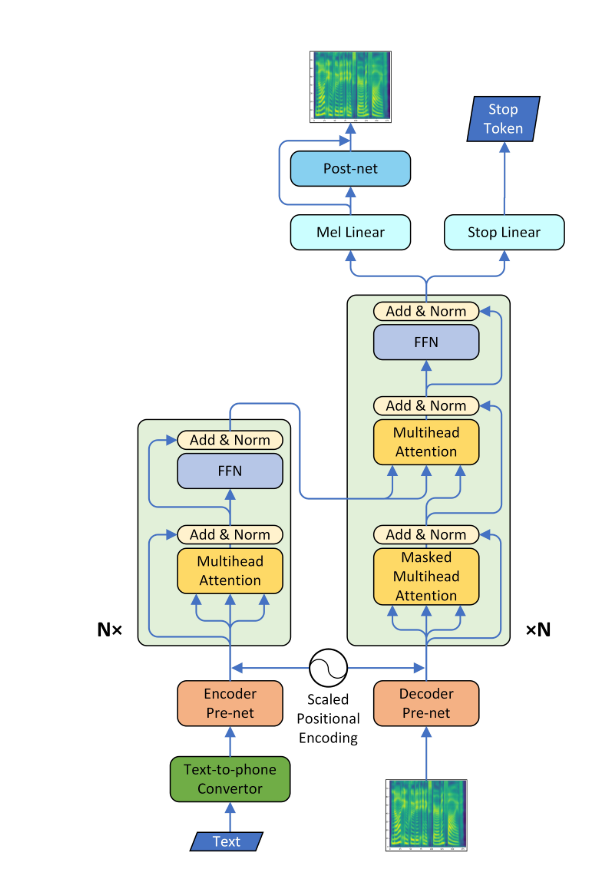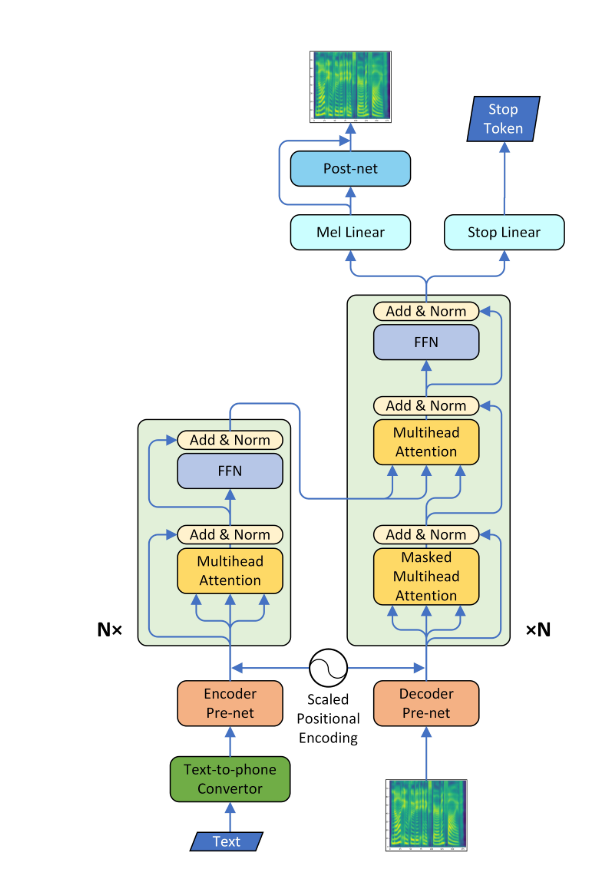

In [29]:
# hyperparameters
device = 'cuda' if torch.cuda.is_available() else 'cpu'
n_embd = 64
n_head = 2
n_layer = 1
dropout = 0.0
audio_block_size = 32000
text_block_size = 200
# ------------

In [30]:
device

'cuda'

In [31]:
class mySequential(nn.Sequential):
    def forward(self, *input):
        for module in self._modules.values():
            input = module(*input)
        return input

In [32]:
class Masked_Self_Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size, block_size):
        super().__init__()
        # Linear Layers to generate key,query and value matrices from the input x
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        
        # The tril that is used for the matrix aggregation trick is registered as a buffer
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))
        
        # Used dropout to prevent overfitting
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B,T,C = x.shape
        k = self.key(x)   # (B,T,C)
        q = self.query(x) # (B,T,C)
        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2,-1) * C**-0.5 # (B, T, C) @ (B, C, T) -> (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        wei = self.dropout(wei)
        # perform the weighted aggregation of the values
        v = self.value(x) # (B,T,C)
        out = wei @ v # (B, T, T) @ (B, T, C) -> (B, T, C)
        return out

class MultiHeadMaskedAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, num_heads, head_size, block_size):
        super().__init__()
        self.heads = nn.ModuleList([Masked_Self_Head(head_size, block_size) for _ in range(num_heads)])
        # This extra linear layer allows the heads to "think" about their assigned attention values
        self.proj = nn.Linear(n_embd, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out
    
class Self_Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size):
        super().__init__()
        # Linear Layers to generate key,query and value matrices from the input x
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
    
        
        # Used dropout to prevent overfitting
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B,T,C = x.shape
        k = self.key(x)   # (B,T,C)
        q = self.query(x) # (B,T,C)
        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2,-1) * C**-0.5 # (B, T, C) @ (B, C, T) -> (B, T, T)
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        wei = self.dropout(wei)
        # perform the weighted aggregation of the values
        v = self.value(x) # (B,T,C)
        out = wei @ v # (B, T, T) @ (B, T, C) -> (B, T, C)
        return out

class MultiHeadUnMaskedAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Self_Head(head_size) for _ in range(num_heads)])
        # This extra linear layer allows the heads to "think" about their assigned attention values
        self.proj = nn.Linear(n_embd, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out
    
class Cross_Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size):
        super().__init__()
        # Linear Layers to generate key,query and value matrices from the input x
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
    
        
        # Used dropout to prevent overfitting
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, y):
        B,T,C = x.shape
        k = self.key(y)   # (B,T,C)
        q = self.query(x) # (B,T,C)
        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2,-1) * C**-0.5 # (B, T, C) @ (B, C, T) -> (B, T, T)
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        wei = self.dropout(wei)
        # perform the weighted aggregation of the values
        v = self.value(y) # (B,T,C)
        out = wei @ v # (B, T, T) @ (B, T, C) -> (B, T, C)
        return out
    
class MultiHeadCrossAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Cross_Head(head_size) for _ in range(num_heads)])
        # This extra linear layer allows the heads to "think" about their assigned attention values
        self.proj = nn.Linear(n_embd, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, y):
        out = torch.cat([h(x, y) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

class FeedFoward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)

class AudioBlock(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, n_embd, n_head):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadMaskedAttention(n_head, head_size, audio_block_size)
        self.ca = MultiHeadCrossAttention(n_head, head_size)
        self.ffwd = FeedFoward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)
        self.ln3 = nn.LayerNorm(n_embd)
        self.ln4 = nn.LayerNorm(n_embd)

    def forward(self, x, y):
#         print('audio here')
        x = x + self.sa(self.ln1(x))
        x = x + self.ca(self.ln2(x), self.ln3(y))
        x = x + self.ffwd(self.ln4(x))
        return x
    
class TextBlock(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, n_embd, n_head):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadUnMaskedAttention(n_head, head_size)
        self.ffwd = FeedFoward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
#         print('text here')
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x

# super simple bigram model
class BigramLanguageModel(nn.Module):

    def __init__(self, vocab_size=65, audio_range=500):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.text_token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.audio_token_embedding_table = nn.Embedding(audio_range, n_embd)
        # We now encode position and add it to our encoding
        self.text_position_embedding_table = nn.Embedding(text_block_size, n_embd)
        self.audio_position_embedding_table = nn.Embedding(audio_block_size, n_embd)
        
        self.audio_blocks = mySequential(*[AudioBlock(n_embd, n_head=n_head) for _ in range(n_layer)])
#         self.audio_blocks = []
#         for _ in range(n_layer):
#             self.audio_blocks.append(AudioBlock(n_embd, n_head=n_head))
        self.ln_f = nn.LayerNorm(n_embd) # final layer norm
        
        self.text_blocks = nn.Sequential(*[TextBlock(n_embd, n_head=n_head) for _ in range(n_layer)])
        self.lm_head = nn.Linear(n_embd, 1)

    def forward(self, audio_idx, text_idx, targets=None):
        B, T = audio_idx.shape

        # idx and targets are both (B,T) tensor of integers
        tok_emb = self.audio_token_embedding_table(audio_idx) # (B,T,C)
        pos_emb = self.audio_position_embedding_table(torch.arange(T, device=device)) # (T,C)
        x = tok_emb + pos_emb # (B,T,C)
        
        B, T = text_idx.shape
        tok_emb = self.text_token_embedding_table(text_idx) # (B,T,C)
        pos_emb = self.text_position_embedding_table(torch.arange(T, device=device)) # (T,C)
        y = tok_emb + pos_emb # (B,T,C)
        
        y = self.text_blocks(y)
#         x = x.double()
#         for audio_block in self.audio_blocks:
#             x = audio_block(x,y) # (B,T,C)
        x = self.audio_blocks(x,y)
        x = self.ln_f(x) # (B,T,C)
        logits = self.lm_head(x) # (B,T,vocab_size)

        return logits

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            idx_cond = idx[:, -block_size:]
            # get the predictions
            logits, loss = self(idx_cond)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx

In [33]:
# from torch.nn import DataParallel

# model = BigramLanguageModel(vocab_size = 76)

# # model.lm_head = torch.nn.Linear(in_features=64, out_features=1, bias=True)

# # Check if multiple GPUs available
# if torch.cuda.device_count() > 1:
#     print("Let's use", torch.cuda.device_count(), "GPUs!")
#     # dim = 0 [30, xxx] -> [10, ...], [10, ...], [10, ...] on 3 GPUs
#     model = DataParallel(model)

# model = model.to(device)

# model

In [34]:
# print(sum(p.numel() for p in model.parameters())/1e6, 'M parameters')

In [35]:
# l = next(iter(dataloaders['train']))
# l.shape

In [36]:
# l[0].shape, l[1].shape

In [37]:
# start_context = torch.zeros(1,8000).to(torch.long)
# start_text = torch.zeros(1,200).to(torch.long)

In [38]:
# start_context.to(device)
# start_text.to(device)

In [39]:
# model = model.double()

# model = model.to(device)

# model(start_context, start_text).shape

In [40]:
import time
import os
import copy

def train_model(model, optimizer, scheduler, num_epochs=25):
    since = time.time()
    train_losses = []
    val_losses = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 1e17

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    start_context = torch.ones(labels.shape[0],8000).to(torch.long)
#                     print(start_context.shape, inputs.shape)
                    output = model(start_context, inputs)
                    
#                     B, T, C = output.shape
#                     output = output.view(B*T, C)
#                     labels = labels.view(B*T)
#                     print(output.shape, labels.shape)
                    output = output.reshape(output.shape[0],-1)
                    loss = F.mse_loss(output.double(), labels.double())
#                     _, predicted = torch.max(output.data, 1)
#                     print(output.shape)
#                     print(labels.shape)                        

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item()
            

            epoch_loss = running_loss / dataset_sizes[phase]
            
            if phase == 'train':
                scheduler.step(epoch_loss)
                
                train_losses.append(epoch_loss)
                
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    }, 'models/latest_checkpoint.pt')
            else:
                val_losses.append(epoch_loss)
            
            print(f'{phase} Loss: {epoch_loss:.7f}')

            # deep copy the model
            if phase == 'val' and epoch_loss < best_loss:
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())
                print('Best checkpoint saved!')
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'best_loss': best_loss
                    }, 'models/best_checkpoint.pt')

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Loss: {best_loss:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, [train_losses], [val_losses]

In [41]:
# num_epochs = 5
# model = model.double()
# optimizer = torch.optim.SGD(model.parameters(), lr=3e-12, momentum=0.9)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=10, factor=0.01)    

# model, train_stats, val_stats = train_model(model, optimizer, scheduler, num_epochs)

Using embeddings on torch.zeros is probably the problem. The use of torch.zeros as an input makes the first masked attention basically useless. I cant use the discrete representations as a sequence, this is a major problem.

I am going to attempt to condense the model into a one input, one output architecture by removing the beginning torch.zeros input and just using the text directly. Hopefully this helps the training, reduces the unused extra size of the model and leads to more clean mapping connections between inputs and outputs. 

In [42]:
# hyperparameters
device = 'cuda' if torch.cuda.is_available() else 'cpu'
n_embd = 64
n_head = 4
n_layer = 4
dropout = 0.0
audio_block_size = 32000
text_block_size = 200
# ------------

In [43]:
class Self_Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size):
        super().__init__()
        # Linear Layers to generate key,query and value matrices from the input x
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
    
        
        # Used dropout to prevent overfitting
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B,T,C = x.shape
        k = self.key(x)   # (B,T,C)
        q = self.query(x) # (B,T,C)
        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2,-1) * C**-0.5 # (B, T, C) @ (B, C, T) -> (B, T, T)
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        wei = self.dropout(wei)
        # perform the weighted aggregation of the values
        v = self.value(x) # (B,T,C)
        out = wei @ v # (B, T, T) @ (B, T, C) -> (B, T, C)
        return out

class MultiHeadUnMaskedAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Self_Head(head_size) for _ in range(num_heads)])
        # This extra linear layer allows the heads to "think" about their assigned attention values
        self.proj = nn.Linear(n_embd, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out
    

class FeedFoward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)

    
class TextBlock(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, n_embd, n_head):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadUnMaskedAttention(n_head, head_size)
        self.ffwd = FeedFoward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
#         print('text here')
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x

# super simple bigram model
class BigramLanguageModel(nn.Module):

    def __init__(self, vocab_size=65, audio_range=500):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.text_token_embedding_table = nn.Embedding(vocab_size, n_embd)
        # We now encode position and add it to our encoding
        self.text_position_embedding_table = nn.Embedding(text_block_size, n_embd)        
#         self.audio_blocks = []
#         for _ in range(n_layer):
#             self.audio_blocks.append(AudioBlock(n_embd, n_head=n_head))
        self.ln_f = nn.LayerNorm(n_embd) # final layer norm
        
        self.text_blocks = nn.Sequential(*[TextBlock(n_embd, n_head=n_head) for _ in range(n_layer)])
        self.lm_head = nn.Linear(n_embd, 160)

    def forward(self, text_idx, targets=None):

        B, T = text_idx.shape
        tok_emb = self.text_token_embedding_table(text_idx) # (B,T,C)
        pos_emb = self.text_position_embedding_table(torch.arange(T, device=device)) # (T,C)
        y = tok_emb + pos_emb # (B,T,C)
        
        y = self.text_blocks(y)
#         x = x.double()
#         for audio_block in self.audio_blocks:
#             x = audio_block(x,y) # (B,T,C)
        x = self.ln_f(y) # (B,T,C)
        logits = self.lm_head(x) # (B,T,vocab_size)

        return logits

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            idx_cond = idx[:, -block_size:]
            # get the predictions
            logits, loss = self(idx_cond)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx

In [44]:
from torch.nn import DataParallel

model = BigramLanguageModel(vocab_size = 76)

# model.lm_head = torch.nn.Linear(in_features=64, out_features=1, bias=True)

# Check if multiple GPUs available
if torch.cuda.device_count() > 1:
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    # dim = 0 [30, xxx] -> [10, ...], [10, ...], [10, ...] on 3 GPUs
    model = DataParallel(model)

model = model.to(device)
model.double()

print(model)
print(sum(p.numel() for p in model.parameters())/1e6, 'M parameters')

Let's use 2 GPUs!
DataParallel(
  (module): BigramLanguageModel(
    (text_token_embedding_table): Embedding(76, 64)
    (text_position_embedding_table): Embedding(200, 64)
    (ln_f): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    (text_blocks): Sequential(
      (0): TextBlock(
        (sa): MultiHeadUnMaskedAttention(
          (heads): ModuleList(
            (0-3): 4 x Self_Head(
              (key): Linear(in_features=64, out_features=16, bias=False)
              (query): Linear(in_features=64, out_features=16, bias=False)
              (value): Linear(in_features=64, out_features=16, bias=False)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (proj): Linear(in_features=64, out_features=64, bias=True)
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (ffwd): FeedFoward(
          (net): Sequential(
            (0): Linear(in_features=64, out_features=256, bias=True)
            (1): ReLU()
            (2): L

In [45]:
# l = next(iter(dataloaders['train']))
# print(l[0])
# print('\n', l[1])
# l[0].shape, l[1].shape

In [46]:
start_text = torch.zeros(1,200).to(torch.long)

In [47]:
res = model(start_text.to(device))
print(res.shape)
res = res.reshape(res.shape[0], -1)
res, res.shape

torch.Size([1, 200, 160])


(tensor([[ 0.3519, -0.9785,  0.5486,  ...,  0.7521, -0.0860,  0.0757]],
        device='cuda:0', dtype=torch.float64, grad_fn=<ReshapeAliasBackward0>),
 torch.Size([1, 32000]))

In [48]:
import time
import os
import copy

def train_model(model, optimizer, scheduler, num_epochs=25):
    since = time.time()
    train_losses = []
    val_losses = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 1e17

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
#                     print(start_context.shape, inputs.shape)
                    output = model(inputs)
                    
#                     B, T, C = output.shape
#                     output = output.view(B*T, C)
#                     labels = labels.view(B*T)
#                     print(output.shape, labels.shape)
                    output = output.reshape(output.shape[0],-1)
                    loss = F.mse_loss(output.double(), labels.double())
#                     _, predicted = torch.max(output.data, 1)
#                     print(output.shape)
#                     print(labels.shape)                        

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item()
            

            epoch_loss = running_loss / dataset_sizes[phase]
            
            if phase == 'train':
                scheduler.step(epoch_loss)
                
                train_losses.append(epoch_loss)
                
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    }, 'models/latest_checkpoint.pt')
            else:
                val_losses.append(epoch_loss)
            
            print(f'{phase} Loss: {epoch_loss:.7f}')

            # deep copy the model
            if phase == 'val' and epoch_loss < best_loss:
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())
                print('Best checkpoint saved!')
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'best_loss': best_loss
                    }, 'models/best_checkpoint.pt')

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Loss: {best_loss:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, [train_losses], [val_losses]

In [49]:
num_epochs = 150
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=10, factor=0.01)    

model, train_stats, val_stats = train_model(model, optimizer, scheduler, num_epochs)

Epoch 0/149
----------
train Loss: 3163.8732468
val Loss: 12271.3879901
Best checkpoint saved!

Epoch 1/149
----------
train Loss: 3163.6102460
val Loss: 12270.3920803
Best checkpoint saved!

Epoch 2/149
----------
train Loss: 3163.3540875
val Loss: 12269.4211874
Best checkpoint saved!

Epoch 3/149
----------
train Loss: 3163.1049365
val Loss: 12268.4733625
Best checkpoint saved!

Epoch 4/149
----------
train Loss: 3162.8618527
val Loss: 12267.5435460
Best checkpoint saved!

Epoch 5/149
----------
train Loss: 3162.6234466
val Loss: 12266.6270011
Best checkpoint saved!

Epoch 6/149
----------
train Loss: 3162.3884886
val Loss: 12265.7199310
Best checkpoint saved!

Epoch 7/149
----------
train Loss: 3162.1559668
val Loss: 12264.8189846
Best checkpoint saved!

Epoch 8/149
----------
train Loss: 3161.9251901
val Loss: 12263.9237413
Best checkpoint saved!

Epoch 9/149
----------
train Loss: 3161.6956982
val Loss: 12263.0337872
Best checkpoint saved!

Epoch 10/149
----------
train Loss: 3161

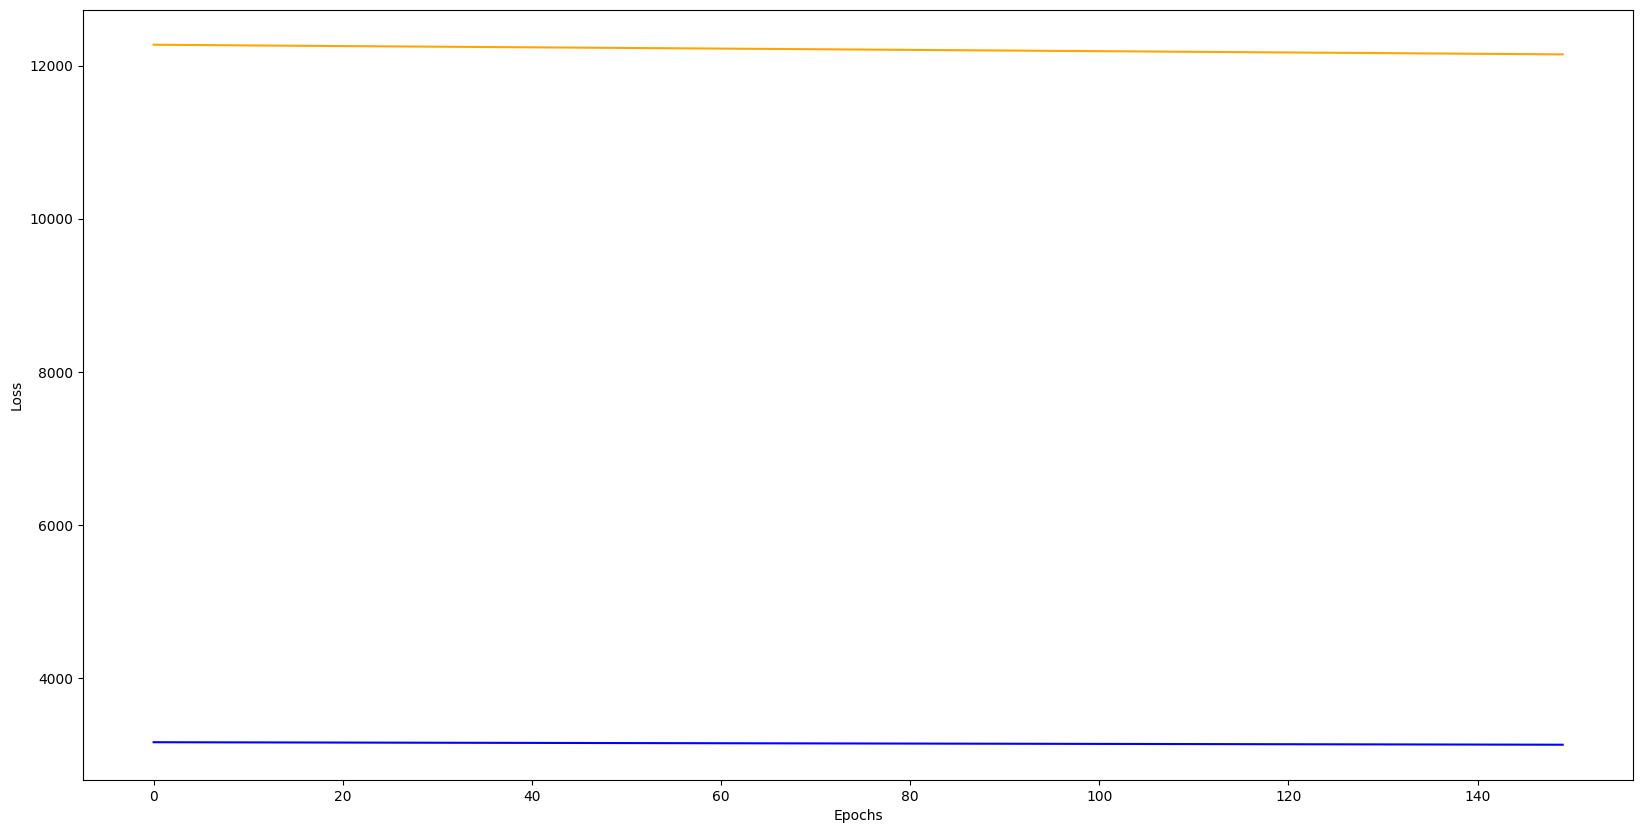

In [50]:
import matplotlib.pyplot as plt
f, axarr = plt.subplots(1,1, figsize=(20, 10))
axarr.plot(train_stats[0], c='blue')
axarr.plot(val_stats[0], c='orange')
axarr.set_xlabel("Epochs")
axarr.set_ylabel("Loss")
f.savefig('visuals.png')

In [51]:
# model = nn.Sequential(nn.Linear(200, 400),
#                      nn.Linear(400, 800),
#                      nn.Linear(800,1600),
#                      nn.Linear(1600, 3200),
#                      nn.Linear(3200, 4000),
#                      nn.Linear(4000,8000))

# model.to(device)
# model.double()
# model

In [52]:
# import time
# import os
# import copy

# def train_model(model, optimizer, scheduler, num_epochs=25):
#     since = time.time()
#     train_losses = []
#     val_losses = []

#     best_model_wts = copy.deepcopy(model.state_dict())
#     best_loss = 1e17

#     for epoch in range(num_epochs):
#         print(f'Epoch {epoch}/{num_epochs - 1}')
#         print('-' * 10)

#         # Each epoch has a training and validation phase
#         for phase in ['train', 'val']:
#             if phase == 'train':
#                 model.train()  # Set model to training mode
#             else:
#                 model.eval()   # Set model to evaluate mode

#             running_loss = 0.0

#             # Iterate over data.
#             for inputs, labels in dataloaders[phase]:
#                 inputs = inputs.to(device)
#                 labels = labels.to(device)

#                 # zero the parameter gradients
#                 optimizer.zero_grad()

#                 # forward
#                 # track history if only in train
#                 with torch.set_grad_enabled(phase == 'train'):
# #                     print(start_context.shape, inputs.shape)
#                     output = model(inputs.double())
                    
# #                     B, T, C = output.shape
# #                     output = output.view(B*T, C)
# #                     labels = labels.view(B*T)
# #                     print(output.shape, labels.shape)
#                     output = output.reshape(output.shape[0],-1)
#                     loss = F.mse_loss(output.double(), labels.double())
# #                     _, predicted = torch.max(output.data, 1)
# #                     print(output.shape)
# #                     print(labels.shape)                        

#                     # backward + optimize only if in training phase
#                     if phase == 'train':
#                         loss.backward()
#                         optimizer.step()

#                 # statistics
#                 running_loss += loss.item()
            

#             epoch_loss = running_loss / dataset_sizes[phase]
            
#             if phase == 'train':
#                 scheduler.step(epoch_loss)
                
#                 train_losses.append(epoch_loss)
                
#                 torch.save({
#                     'epoch': epoch,
#                     'model_state_dict': model.state_dict(),
#                     'optimizer_state_dict': optimizer.state_dict(),
#                     }, 'models/latest_checkpoint.pt')
#             else:
#                 val_losses.append(epoch_loss)
            
#             print(f'{phase} Loss: {epoch_loss:.7f}')

#             # deep copy the model
#             if phase == 'val' and epoch_loss < best_loss:
#                 best_loss = epoch_loss
#                 best_model_wts = copy.deepcopy(model.state_dict())
#                 print('Best checkpoint saved!')
#                 torch.save({
#                     'epoch': epoch,
#                     'model_state_dict': model.state_dict(),
#                     'optimizer_state_dict': optimizer.state_dict(),
#                     'best_loss': best_loss
#                     }, 'models/best_checkpoint.pt')

#         print()

#     time_elapsed = time.time() - since
#     print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
#     print(f'Best val Loss: {best_loss:4f}')

#     # load best model weights
#     model.load_state_dict(best_model_wts)
#     return model, [train_losses], [val_losses]

In [53]:
# num_epochs = 100
# optimizer = torch.optim.AdamW(model.parameters(), lr=3e-6)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=10, factor=0.01)    

# model, train_stats, val_stats = train_model(model, optimizer, scheduler, num_epochs)

If a model this simple, can't get steady loss decrease, there must be something wrong with the data.

In [54]:
# data = pd.read_csv('/kaggle/input/the-lj-speech-dataset/LJSpeech-1.1/metadata.csv', sep='|', names=["File", "Transcription2", "Transcription"]).drop(columns=['Transcription2']).dropna().iloc[:20]

In [55]:
# model = EncodecModel.encodec_model_24khz()

# tsizes = []
# asizes = []

# for i in range(20):

#     row = data.iloc[i]
#     text = torch.tensor(encode(row.Transcription), dtype=torch.long)
#     if len(text) < 200:
#         text = torch.cat([text, torch.ones(200-len(text))*75])

#     tsizes.append(text.shape)

#     wav, sr = torchaudio.load("/kaggle/input/the-lj-speech-dataset/LJSpeech-1.1/wavs/"+row.File+".wav")
#     wav = convert_audio(wav, sr, model.sample_rate, model.channels)
#     wav = wav.unsqueeze(0)

#     # Extract discrete codes from EnCodec
#     with torch.no_grad():
#         encoded_frames = model.encode(wav)
#     audio = encoded_frames[0][0]
#     asizes.append(audio.shape)
#     audio = audio.reshape(-1)
#     if len(audio) < 8000:
#         audio = torch.cat([audio, torch.zeros(8000-len(audio))])
#     elif len(audio) > 8000:
#         print('Longer audio representation than fixed length')

# print(tsizes, '\n', asizes)

In [56]:
# import os
# import torch
# from torch.utils.data import Dataset
# from torchvision import datasets
# from torchvision.transforms import ToTensor
# import matplotlib.pyplot as plt

# class AudioDataset(Dataset):
#     def __init__(self,train):
#         self.data = pd.read_csv('/kaggle/input/the-lj-speech-dataset/LJSpeech-1.1/metadata.csv', sep='|', names=["File", "Transcription2", "Transcription"]).drop(columns=['Transcription2']).dropna().iloc[:20]
        
#         if train:
#             self.data = self.data.iloc[:len(self.data)*8//10]
#         else:
#             self.data = self.data.iloc[len(self.data)*8//10:]
        
#         self.model = EncodecModel.encodec_model_24khz()
        
#         self.model.set_target_bandwidth(6.0)
        

#     def __len__(self):
#         return len(self.data)

#     def __getitem__(self, idx):
#         row = self.data.iloc[idx]
#         text = torch.tensor(encode(row.Transcription), dtype=torch.long)
#         if len(text) < 200:
#             text = torch.cat([text, torch.ones(200-len(text))*75])
        
#         wav, sr = torchaudio.load("/kaggle/input/the-lj-speech-dataset/LJSpeech-1.1/wavs/"+row.File+".wav")
#         wav = convert_audio(wav, sr, self.model.sample_rate, self.model.channels)
#         wav = wav.unsqueeze(0)

#         # Extract discrete codes from EnCodec
#         with torch.no_grad():
#             encoded_frames = self.model.encode(wav)
#         audio = encoded_frames[0][0]
#         audio = audio.reshape(-1)
#         if len(audio) < 32000:
#             audio = torch.cat([audio, torch.zeros(32000-len(audio))])
#         elif len(audio) > 32000:
#             raise Exception('Longer audio representation than fixed length')
        
#         return text.to(torch.long), audio

In [57]:
# from torch.utils.data import DataLoader

# train_data = AudioDataset(train=True)
# val_data = AudioDataset(train=False)

# batch_size = 7

# trainloader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=0)
# valloader = DataLoader(val_data, batch_size=batch_size, shuffle=False, num_workers=0)

# dataloaders = {'train':trainloader, 'val':valloader}
# dataset_sizes = {'train':len(train_data), 'val':len(val_data)}

In [58]:
# from torch.nn import DataParallel

# model = nn.Sequential(nn.Linear(200, 1600),
#                      nn.Linear(1600, 5000),
#                      nn.Linear(5000, 32000))

# # Check if multiple GPUs available
# if torch.cuda.device_count() > 1:
#     print("Let's use", torch.cuda.device_count(), "GPUs!")
#     # dim = 0 [30, xxx] -> [10, ...], [10, ...], [10, ...] on 3 GPUs
#     model = DataParallel(model)

# model.double()

# model.to(device)
# model

In [59]:
# import time
# import os
# import copy

# def train_model(model, optimizer, scheduler, num_epochs=25):
#     since = time.time()
#     train_losses = []
#     val_losses = []

#     best_model_wts = copy.deepcopy(model.state_dict())
#     best_loss = 1e17

#     for epoch in range(num_epochs):
#         print(f'Epoch {epoch}/{num_epochs - 1}')
#         print('-' * 10)

#         # Each epoch has a training and validation phase
#         for phase in ['train', 'val']:
#             if phase == 'train':
#                 model.train()  # Set model to training mode
#             else:
#                 model.eval()   # Set model to evaluate mode

#             running_loss = 0.0

#             # Iterate over data.
#             for inputs, labels in dataloaders[phase]:
#                 inputs = inputs.to(device)
#                 labels = labels.to(device)

#                 # zero the parameter gradients
#                 optimizer.zero_grad()

#                 # forward
#                 # track history if only in train
#                 with torch.set_grad_enabled(phase == 'train'):
# #                     print(start_context.shape, inputs.shape)
#                     output = model(inputs.double())
                    
# #                     B, T, C = output.shape
# #                     output = output.view(B*T, C)
# #                     labels = labels.view(B*T)
# #                     print(output.shape, labels.shape)
#                     output = output.reshape(output.shape[0],-1)
#                     loss = F.mse_loss(output.double(), labels.double())
# #                     _, predicted = torch.max(output.data, 1)
# #                     print(output.shape)
# #                     print(labels.shape)                        

#                     # backward + optimize only if in training phase
#                     if phase == 'train':
#                         loss.backward()
#                         optimizer.step()

#                 # statistics
#                 running_loss += loss.item()
            

#             epoch_loss = running_loss / dataset_sizes[phase]
            
#             if phase == 'train':
#                 scheduler.step(epoch_loss)
                
#                 train_losses.append(epoch_loss)
                
#                 torch.save({
#                     'epoch': epoch,
#                     'model_state_dict': model.state_dict(),
#                     'optimizer_state_dict': optimizer.state_dict(),
#                     }, 'models/latest_checkpoint.pt')
#             else:
#                 val_losses.append(epoch_loss)
            
#             print(f'{phase} Loss: {epoch_loss:.7f}')

#             # deep copy the model
#             if phase == 'val' and epoch_loss < best_loss:
#                 best_loss = epoch_loss
#                 best_model_wts = copy.deepcopy(model.state_dict())
#                 print('Best checkpoint saved!')
#                 torch.save({
#                     'epoch': epoch,
#                     'model_state_dict': model.state_dict(),
#                     'optimizer_state_dict': optimizer.state_dict(),
#                     'best_loss': best_loss
#                     }, 'models/best_checkpoint.pt')

#         print()

#     time_elapsed = time.time() - since
#     print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
#     print(f'Best val Loss: {best_loss:4f}')

#     # load best model weights
#     model.load_state_dict(best_model_wts)
#     return model, [train_losses], [val_losses]

In [60]:
# num_epochs = 100
# optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=10, factor=0.01)    

# model, train_stats, val_stats = train_model(model, optimizer, scheduler, num_epochs)